# Routing, speed imputation, and travel times

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import multiprocessing as mp
import numpy as np
import osmnx as ox
%matplotlib inline
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.16.0'

In [2]:
place = 'Piedmont, California, USA'
G = ox.graph_from_place(place, network_type='drive')

## 1. Fast nearest node/edge search with OSMnx

In [3]:
# convert projected graph to edges geodataframe
gdf_edges = ox.graph_to_gdfs(ox.project_graph(G), nodes=False)

# list of lats and lngs
lngs = gdf_edges.head().centroid.map(lambda x: x.coords[0][0])
lats = gdf_edges.head().centroid.map(lambda x: x.coords[0][1])

# the lat, lng at the spatial center of the graph
lng, lat = gdf_edges.unary_union.centroid.coords[0]
center_point = lat, lng

In [4]:
# find the nearest node to some point
center_node = ox.get_nearest_node(G, center_point)

In [5]:
# find the nearest nodes to a set of points
# optionally specify `method` use use a kdtree or balltree index
nearest_nodes = ox.get_nearest_nodes(G, lngs, lats, method='kdtree')

In [6]:
# find the nearest edge to some point
nearest_edge = ox.get_nearest_edge(G, center_point)

In [7]:
# find the nearest edges to some set of points
# optionally specify `method` use use a kdtree or balltree index
nearest_edges = ox.get_nearest_edges(G, lngs, lats)

## 2. Basic routing by distance

Pick two nodes. Then find the shortest path between origin and destination, using weight='length' to find the shortest path by minimizing distance traveled (otherwise it treats each edge as weight=1).

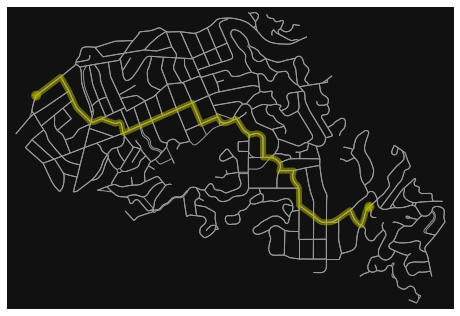

In [8]:
# find the shortest path (by distance) between these nodes then plot it
orig = list(G)[0]
dest = list(G)[120]
route = ox.shortest_path(G, orig, dest, weight='length')
fig, ax = ox.plot_graph_route(G, route, route_color='y', route_linewidth=6, node_size=0)

Or get *k* shortest paths, weighted by some attribute:

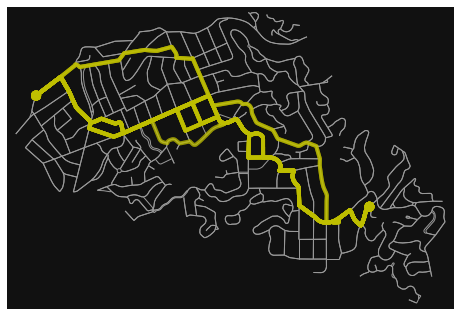

In [9]:
routes = ox.k_shortest_paths(G, orig, dest, k=30, weight='length')
fig, ax = ox.plot_graph_routes(G, list(routes), route_colors='y', route_linewidth=4, node_size=0)

## 3. Imputing travel speeds and times

The `add_edge_speeds` function add edge speeds (km per hour) to graph as new `speed_kph` edge attributes. Imputes free-flow travel speeds for all edges based on mean `maxspeed` value of edges, per highway type. This mean-imputation can obviously be imprecise, and the caller can override it by passing in `hwy_speeds` and/or `fallback` arguments that correspond to local speed limit standards. See docstring for details.

In [10]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [11]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

,length,speed_kph,travel_time
highway,,,
residential,126.5,24.1,18.9
secondary,120.6,44.3,9.9
tertiary,105.2,40.2,9.4
tertiary_link,64.6,36.2,6.4
unclassified,49.3,36.2,4.9


In [12]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {'residential': 35,
              'secondary': 50,
              'tertiary': 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [13]:
# calculate two routes by minimizing travel distance vs travel time
orig = list(G)[1]
dest = list(G)[120]
route1 = ox.shortest_path(G, orig, dest, weight='length')
route2 = ox.shortest_path(G, orig, dest, weight='travel_time')

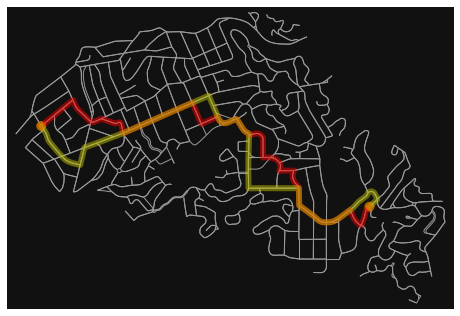

In [14]:
# plot the routes
fig, ax = ox.plot_graph_routes(G, routes=[route1, route2], route_colors=['r', 'y'],
                               route_linewidth=6, node_size=0)

In [15]:
# compare the two routes
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'length')))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'length')))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'travel_time')))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'travel_time')))
print('Route 1 is', route1_length, 'meters and takes', route1_time, 'seconds.')
print('Route 2 is', route2_length, 'meters and takes', route2_time, 'seconds.')

Route 1 is 3625 meters and takes 316 seconds.
Route 2 is 3799 meters and takes 251 seconds.


The yellow route minimizes travel time, and is thus longer but faster than the red route.

For more examples of travel time, see the [isochrones example](13-isolines-isochrones.ipynb).

For more examples of routing, including using elevation as an impedance, see the [elevations example](12-node-elevations-edge-grades.ipynb).

## 4. Multiprocessing

Calculating lots of shortest-paths can be slow, but fortunately it's easily parallelized.

In [16]:
n = 100000  # we'll calculate 100,000 shortest-path routes
cpus = mp.cpu_count() - 1  # how many CPU cores to utilize (careful with your RAM!)

In [17]:
def shortest_path(G, orig, dest):
    try:
        return ox.shortest_path(G, orig, dest, weight='travel_time')
    except:
        # for unsolvable routes (due to directed graph perimeter effects)
        return None

In [18]:
# create iterable parameters (O-D pairs) for each function run
nodes = np.array(G.nodes())
origs = np.random.choice(nodes, size=n, replace=True)
dests = np.random.choice(nodes, size=n, replace=True)
params = ((G, orig, dest) for orig, dest in zip(origs, dests))

In [19]:
# create a pool of worker processes
pool = mp.Pool(cpus)

# map the function/parameters to the worker processes
sma = pool.starmap_async(shortest_path, params)

In [20]:
%%time
# get the results, close the pool, wait for worker processes to all exit
routes = sma.get()
pool.close()
pool.join()

CPU times: user 2.06 s, sys: 69 ms, total: 2.13 s
Wall time: 16.6 s


In [21]:
# how many total results did we get
print(len(routes))

# and how many were solvable paths
routes_valid = [r for r in routes if r is not None]
print(len(routes_valid))

100000
99089


## 5. Miscellaneous routing notes

The routing correctly handles one-way streets:

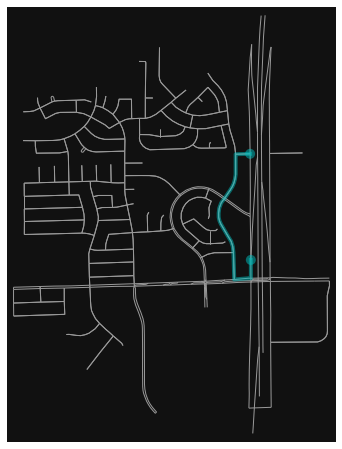

In [22]:
G2 = ox.graph_from_address('N. Sicily Pl., Chandler, Arizona', dist=800, network_type='drive', truncate_by_edge=True)
origin = (33.307792, -111.894940)
destination = (33.312994, -111.894998)
origin_node = ox.get_nearest_node(G2, origin)
destination_node = ox.get_nearest_node(G2, destination)
route = ox.shortest_path(G2, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G2, route, route_color='c', node_size=0)

Also, when there are parallel edges between nodes in the route, OSMnx picks the shortest edge to plot:

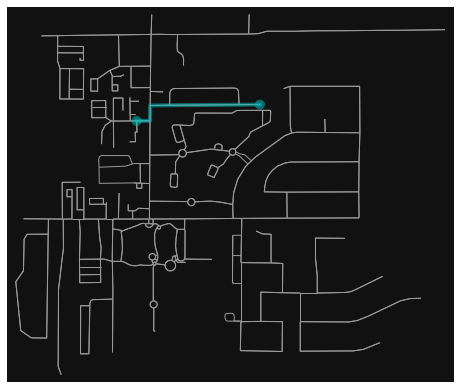

In [23]:
location_point = (33.299896, -111.831638)
G2 = ox.graph_from_point(location_point, dist=400, truncate_by_edge=True)
origin = (33.301821, -111.829871)
destination = (33.301402, -111.833108)
origin_node = ox.get_nearest_node(G2, origin)
destination_node = ox.get_nearest_node(G2, destination)
route = ox.shortest_path(G2, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G2, route, route_color='c', node_size=0)